In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

In [5]:
from wurlitzer import sys_pipes
from plotnine import *
from mizani.formatters import percent_format
import itertools
import pandas as pd
import numpy as np

from UCP.data import UCPData
import UCP.output as ucp_out
import UCP.model as modeller
import UCP.output.check_solution as ck
import UCP.output.charts as charts
from generic.optimization.solution_extraction import extract_solution

In [6]:
theme_set(theme_bw() + theme(figure_size=(10, 10 / 1.61)))

In [7]:
plants = pd.read_csv("./UCP/example_data/plants.csv")
loads = pd.read_csv("./UCP/example_data/loads.csv")
data = UCPData(plants, loads)

# Data

Thermal plants: table describing thermal plants

* `plant`: plant id
* `l_cost`: cost function slope
* `c_cost`: cost function constant term
* `min_power`, `max_power`: minimum and maximum production value when plant is on
* `min_on`, `min_off`: minimum on and off time (in hours)


Loads: hourly demand. Relevant fields:
* `period`: hour
* `value`: load

In [19]:
data.thermal_plants

,plant,l_cost,c_cost,min_power,max_power,min_on,min_off
0,0,4.19755,116.761,45.9688,127.349,1,1
1,1,6.79912,287.115,62.7142,185.865,2,3
2,2,7.05905,324.258,69.9785,160.913,2,3
3,3,7.52869,521.159,96.7459,236.831,6,6
4,4,7.02039,200.095,51.2834,151.001,2,3
5,5,7.07212,196.285,60.2507,183.386,2,3
6,6,4.44010,144.004,43.7572,104.979,1,1
7,7,4.92397,119.922,47.1735,113.187,1,1
8,8,4.61960,114.053,42.8216,112.959,1,1
9,9,6.78825,269.271,68.1361,155.159,2,3


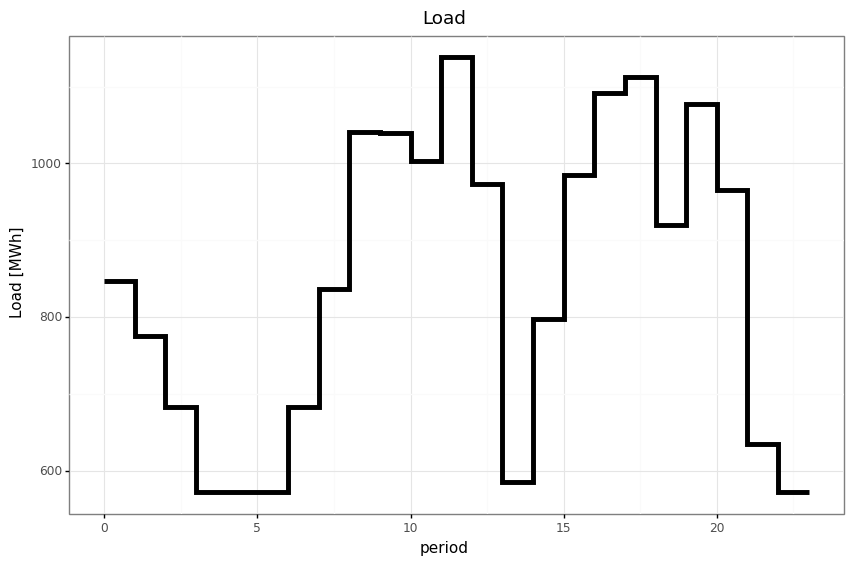

<ggplot: (8729080247480)>

In [20]:
ggplot(data.loads, aes("period", "value")) + geom_step(size=2) + labs(y="Load [MWh]") + ggtitle("Load")

# Solution

In [9]:
ucp = modeller.create_model(data)

In [10]:
with sys_pipes():
    ucp.model.solve()
print(f"Cost: {ucp.model.objective.value()}")

Welcome to the CBC MILP Solver 
Version: 2.9.0 
Build Date: Feb 12 2015 

command line - /home/ataverna_personal/miniconda3/envs/experiments/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/31c7529841c54bf5a1db796c329d74d1-pulp.mps branch printingOptions all solution /tmp/31c7529841c54bf5a1db796c329d74d1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1909 COLUMNS
At line 8911 RHS
At line 10816 BOUNDS
At line 11537 ENDATA
Problem MODEL has 1904 rows, 1008 columns and 5033 elements
Coin0008I MODEL read with 0 errors
Continuous objective value is 137513 - 0.02 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 271 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 146 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 38 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 36 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 34 strengthened rows, 0 

# Output

In [11]:
solution = extract_solution(ucp)

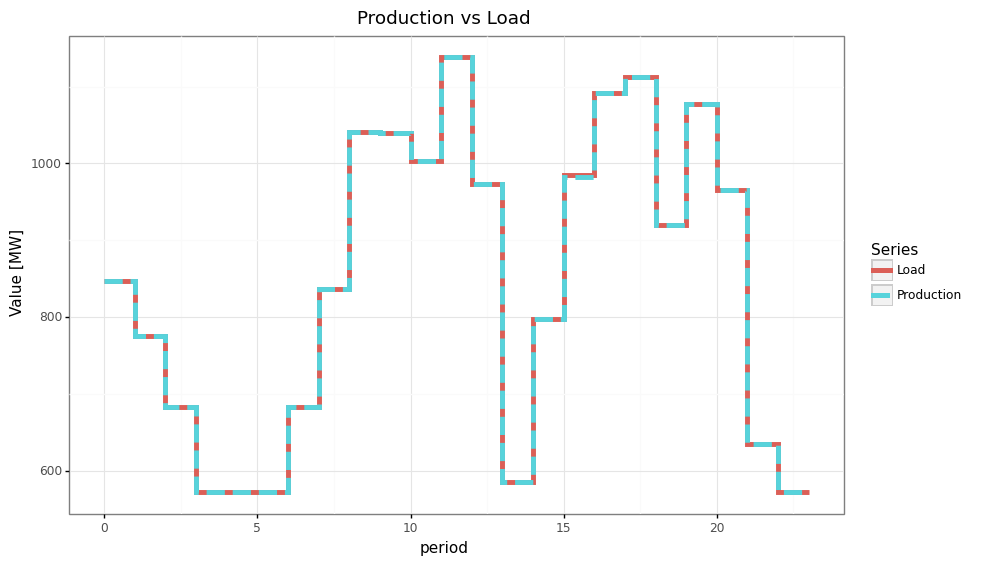

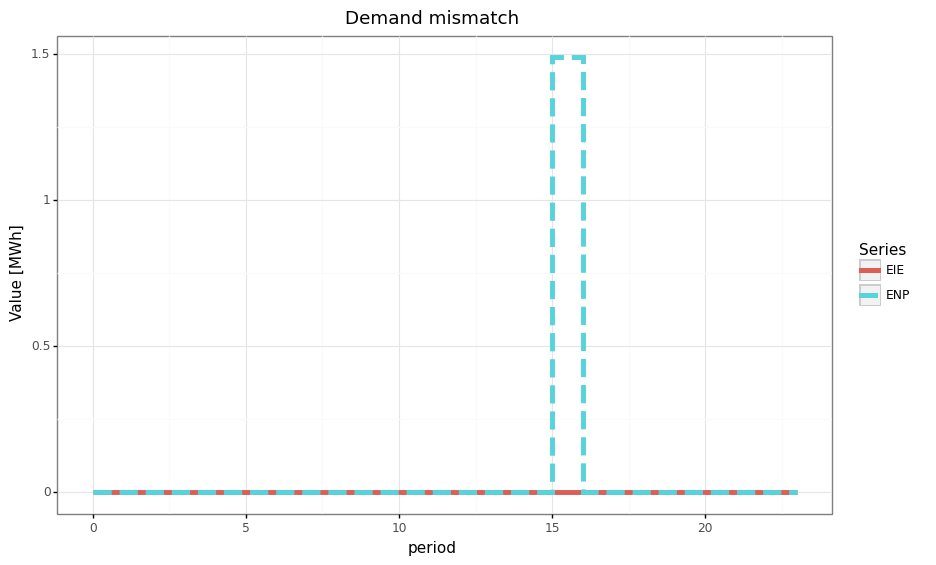

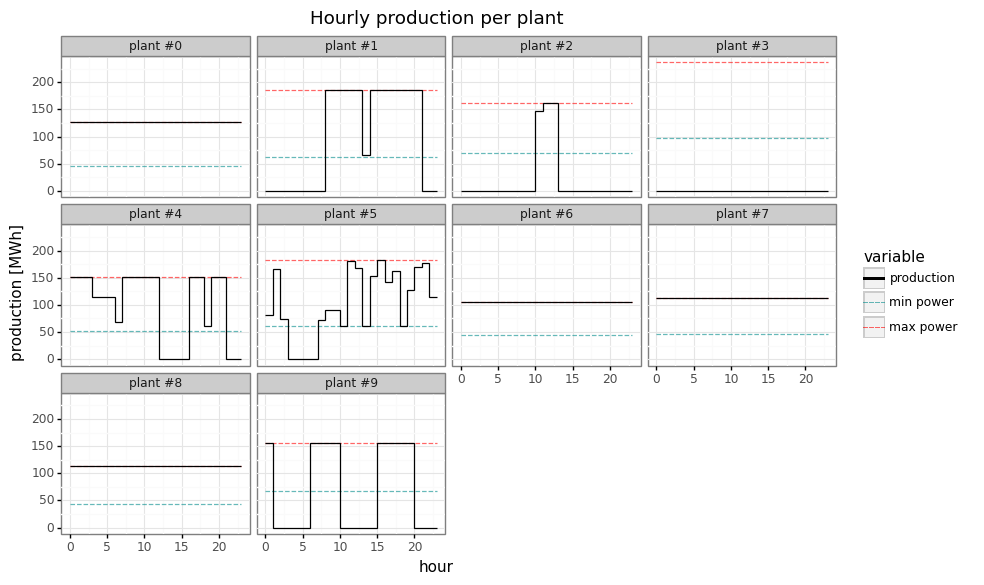

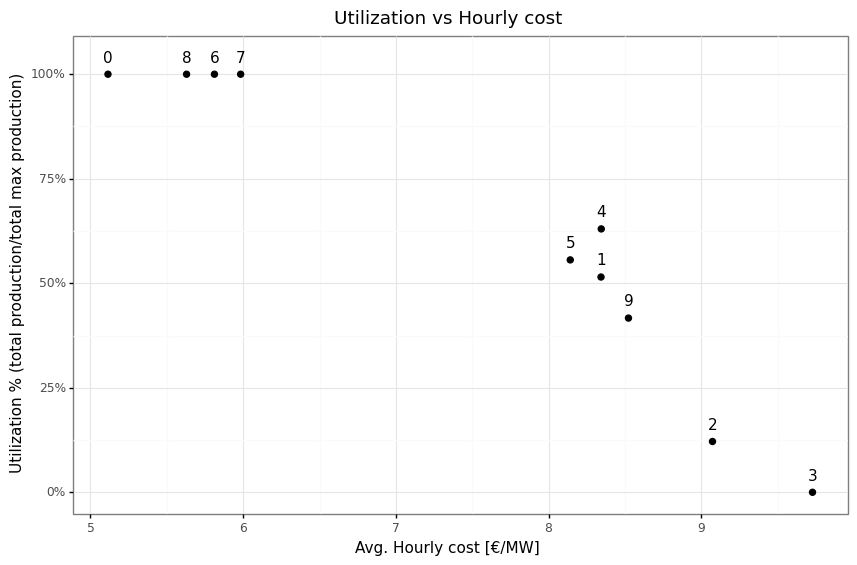

In [12]:
plots = [charts.total_production(data, solution),
 charts.enp_vs_eie(data, solution),
 charts.production_by_plant(data, solution),
 charts.plant_utilization(data, solution)]

for p in plots:
    print(p)